In [1]:
!pip install lightgbm xgboost

In [2]:
# --- Library imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')



In [3]:
# --- Load Titanic CSV files ---
titanic_train = pd.read_csv("Titanic_train.csv")
titanic_test = pd.read_csv("Titanic_test.csv")

In [4]:
# Quick peek at the training data
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# --- Missing values summary ---
titanic_train.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


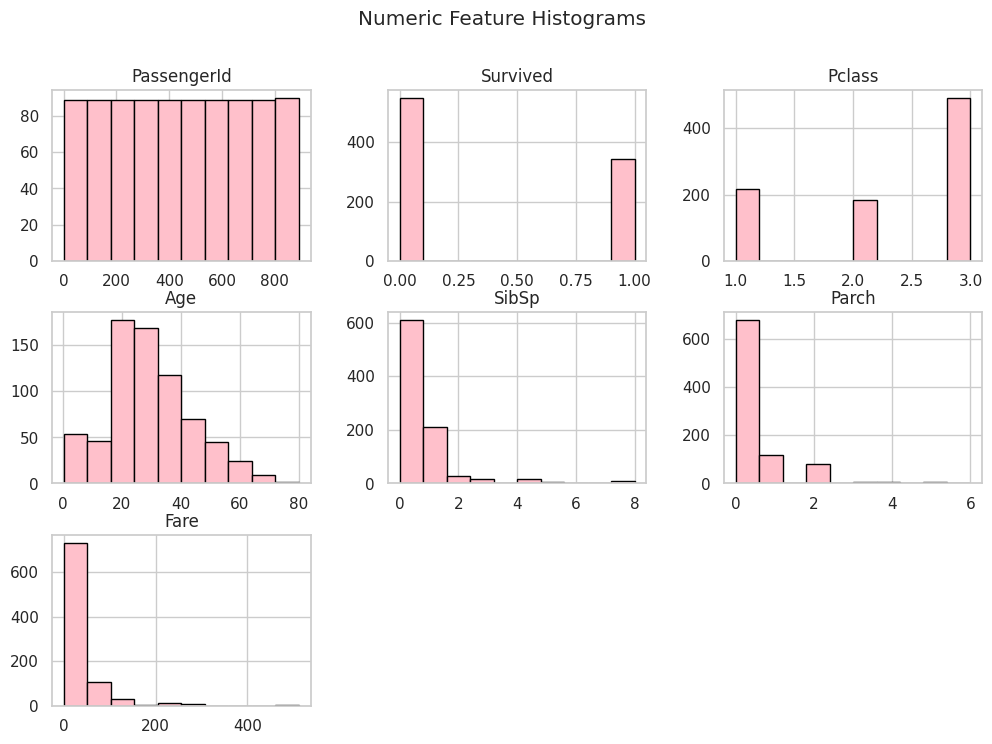

In [7]:
# --- Distribution plots for numeric columns ---
titanic_train.hist(figsize=(12, 8), color='pink', edgecolor='black')
plt.suptitle('Numeric Feature Histograms')
plt.show()

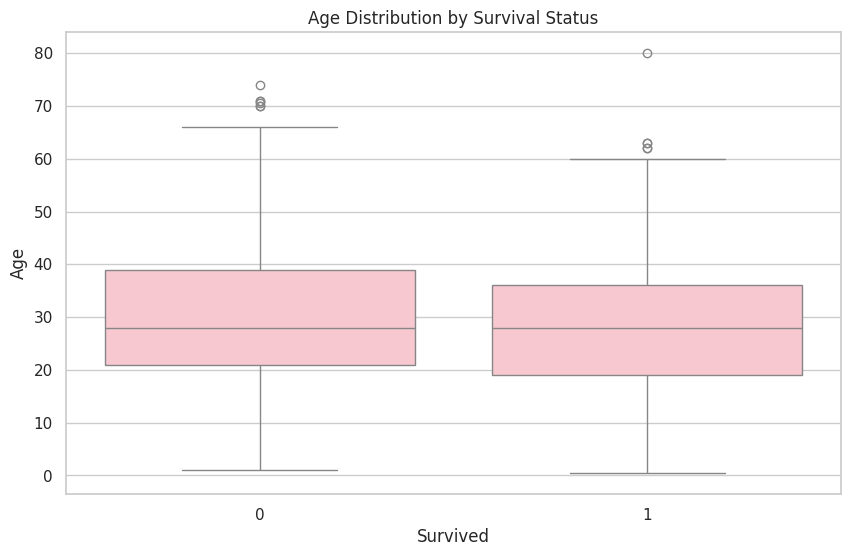

In [9]:
# Boxplot for Age grouped by survival
plt.figure(figsize=(10, 6))
sns.boxplot(x='Survived', y='Age', data=titanic_train, color='pink')
plt.title('Age Distribution by Survival Status')
plt.show()

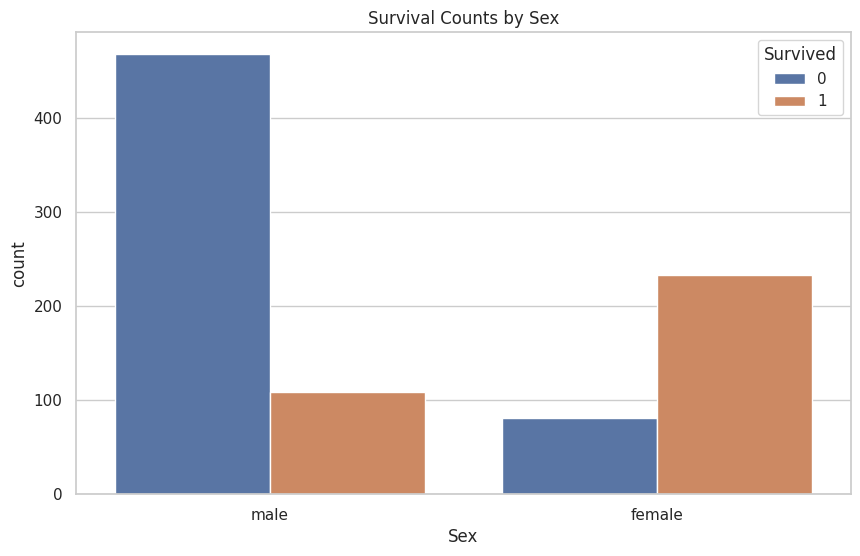

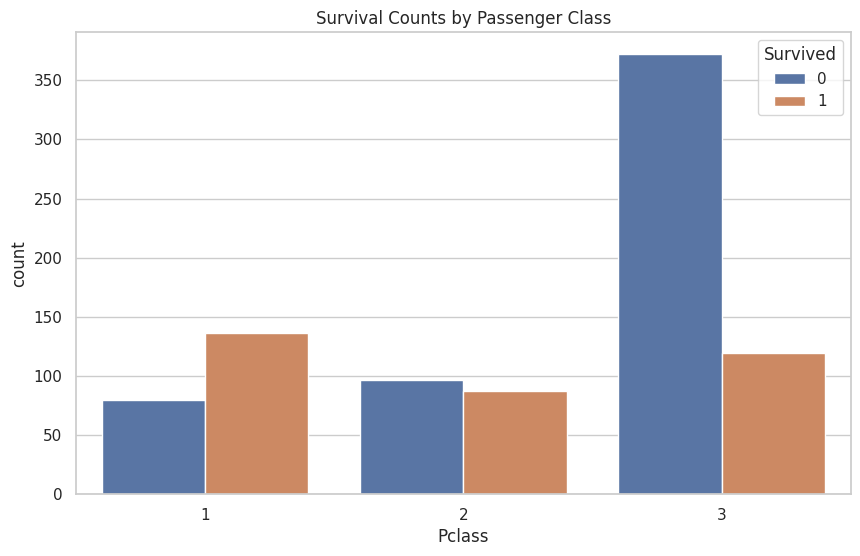

In [11]:
# Count plots to inspect categorical relationships with target
plt.figure(figsize=(10, 6))
sns.countplot(x='Sex', hue='Survived', data=titanic_train)
plt.title('Survival Counts by Sex')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Pclass', hue='Survived', data=titanic_train)
plt.title('Survival Counts by Passenger Class')
plt.show()


In [12]:
# --- Combine train & test to apply consistent preprocessing ---
combined = pd.concat([titanic_train, titanic_test], sort=False)

In [13]:
# Impute common missing values
combined['Age'].fillna(combined['Age'].median(), inplace=True)
combined['Fare'].fillna(combined['Fare'].median(), inplace=True)
combined['Embarked'].fillna(combined['Embarked'].mode()[0], inplace=True)
combined['Cabin'].fillna('Unknown', inplace=True)

In [14]:
# Remove columns considered less informative for this exercise
combined.drop(['Ticket', 'Name'], axis=1, inplace=True)

In [15]:
# Convert categorical columns into dummy/indicator variables
combined = pd.get_dummies(combined, columns=['Sex', 'Embarked', 'Cabin'], drop_first=True)

In [16]:
# Separate the combined frame back into training and test sets
titanic_train = combined[~combined['Survived'].isnull()]
titanic_test = combined[combined['Survived'].isnull()].drop('Survived', axis=1)

In [17]:
# --- Prepare features and labels for modeling ---
X_feat = titanic_train.drop(['Survived', 'PassengerId'], axis=1)
y_target = titanic_train['Survived']
X_train, X_val, y_train, y_val = train_test_split(X_feat, y_target, test_size=0.2, random_state=42)

In [18]:
# --- Grid search for LightGBM hyperparameters ---
from sklearn.model_selection import GridSearchCV, StratifiedKFold

lgb_grid_params = {
    'num_leaves': [31, 50],
    'learning_rate': [0.1, 0.05],
    'n_estimators': [100, 200]
}

lgb_clf = lgb.LGBMClassifier()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lgb_search = GridSearchCV(lgb_clf, lgb_grid_params, cv=skf, scoring='f1', n_jobs=-1)
lgb_search.fit(X_train, y_train)

opt_lgb_model = lgb_search.best_estimator_
print("Optimal LightGBM Params:", lgb_search.best_params_)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [19]:
# --- Grid search for XGBoost hyperparameters ---
xgb_grid_params = {
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.05],
    'n_estimators': [100, 200]
}

xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_search = GridSearchCV(xgb_clf, xgb_grid_params, cv=skf, scoring='f1', n_jobs=-1)
xgb_search.fit(X_train, y_train)

opt_xgb_model = xgb_search.best_estimator_
print("Optimal XGBoost Params:", xgb_search.best_params_)

Optimal XGBoost Params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}


In [20]:
# --- Evaluate tuned LightGBM on validation set ---
opt_lgb_model.fit(X_train, y_train)
lgb_val_preds = opt_lgb_model.predict(X_val)

print("LightGBM (after tuning) - Validation Metrics:")
print(classification_report(y_val, lgb_val_preds))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [21]:
# --- Evaluate tuned XGBoost on validation set ---
opt_xgb_model.fit(X_train, y_train)
xgb_val_preds = opt_xgb_model.predict(X_val)

print("XGBoost (after tuning) - Validation Metrics:")
print(classification_report(y_val, xgb_val_preds))

XGBoost (after tuning) - Validation Metrics:
              precision    recall  f1-score   support

         0.0       0.83      0.88      0.85       105
         1.0       0.81      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



In [22]:
# --- Train & evaluate a default LightGBM (no tuning) ---
vanilla_lgb = lgb.LGBMClassifier()
vanilla_lgb.fit(X_train, y_train)
vanilla_lgb_preds = vanilla_lgb.predict(X_val)

print("LightGBM (default) - Validation Metrics:")
print(classification_report(y_val, vanilla_lgb_preds))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [23]:
# --- Train & evaluate a default XGBoost (no tuning) ---
vanilla_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
vanilla_xgb.fit(X_train, y_train)
vanilla_xgb_preds = vanilla_xgb.predict(X_val)

print("XGBoost (default) - Validation Metrics:")
print(classification_report(y_val, vanilla_xgb_preds))

XGBoost (default) - Validation Metrics:
              precision    recall  f1-score   support

         0.0       0.82      0.85      0.84       105
         1.0       0.77      0.74      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179



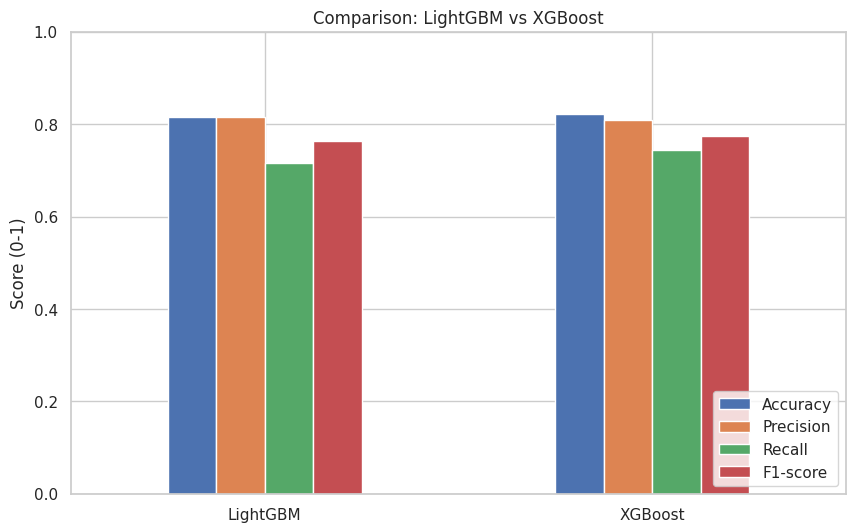

In [24]:
# --- Compile key scores and visualize model comparison ---
comparison_scores = {
    "Accuracy": [accuracy_score(y_val, lgb_val_preds), accuracy_score(y_val, xgb_val_preds)],
    "Precision": [precision_score(y_val, lgb_val_preds), precision_score(y_val, xgb_val_preds)],
    "Recall": [recall_score(y_val, lgb_val_preds), recall_score(y_val, xgb_val_preds)],
    "F1-score": [f1_score(y_val, lgb_val_preds), f1_score(y_val, xgb_val_preds)]
}
comparison_df = pd.DataFrame(comparison_scores, index=['LightGBM', 'XGBoost'])

comparison_df.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison: LightGBM vs XGBoost')
plt.ylabel('Score (0-1)')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()